In [142]:
import pandas as pd
import xgboost as xgb
import random
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pickle as pkl

from typing import List
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics

module_path = os.path.abspath(os.path.join('../CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

In [234]:

def normalize_data(x_train):
    
    x_normalized_train = (x_train - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))

    return x_normalized_train


def subgroup_ate(
    method: str,
    features: List[int],
    x_train: np.ndarray,
    x_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    estimated_ate_test: np.ndarray,
) -> List[np.ndarray]:

    
    xgb_model = xgb.XGBClassifier(  
        # max_depth=3,
        # reg_lambda=2,
        # min_split_loss=2
    )

    xgb_model.fit(x_train[:, features], y_train)
    y_pred = xgb_model.predict(x_test[:, features])
    
    auroc = metrics.roc_auc_score(y_test, y_pred)

    
    ate = np.sum(estimated_ate_test[y_pred == 1])/len(estimated_ate_test)
    
    print("===================")
    print("%s - auroc %s"%(method, auroc))
    print("%s - ATE %s"%(method, ate))

    
    return auroc, ate

def feature_idx(
    dataset: np.ndarray,
    method: str,
    cohort: str,
    learner: str,
    shuffle: str,
    features: List[str]=None
)-> List[int]:
    
    if method == "shap":
        file_path = f"../results/{cohort}/naive_shap_top_5_features_shuffle_{shuffle}_{learner}.csv"
    elif method == "ig":
        file_path = f"../results/{cohort}/integrated_gradients_top_5_features_shuffle_{shuffle}_{learner}.csv"
    elif method == "baseline_shap":
        file_path = f"../results/{cohort}/baseline_shapley_value_sampling_top_5_features_shuffle_{shuffle}_{learner}.csv"
    elif method == "marginal_shap":
        file_path = f"../results/{cohort}/marginal_shapley_value_sampling_top_5_features_shuffle_{shuffle}_{learner}.csv"
    
    
    df = pd.read_csv(file_path,keep_default_na=False)
    
    df_sorted = df.sort_values(
        by='count (%)', 
        ascending=False
    )
    print(df_sorted["feature"].head(5).tolist())
    
    if features != None:
        indices  = [ x.columns.get_loc(col) for col in features ]

    else:
        indices  = [ x.columns.get_loc(col) for col in df_sorted["feature"].head(5) ]
    
    indices = [i-1 if i > treatment_index else i for i in indices]
    
    return indices

In [235]:


def gen_data(random_state=0):
    
    ist3 = pd.read_sas("../data/datashare_aug2015.sas7bdat")
    
    outcome_col = "aliveind6"
    treatment_col = "itt_treat"
    
    continuous_vars = [
        "gender",
        "age",
        "weight",
        "glucose",
        # "gcs_eye_rand",
        # "gcs_motor_rand",
        # "gcs_verbal_rand",
        "gcs_score_rand",   
         "nihss" ,
         "sbprand",
         "dbprand",
         "antiplat_rand",
         "atrialfib_rand"
    ]

    cate_variables = [
         # "livealone_rand",
         # "indepinadl_rand",
         "infarct",
         # "atrialfib_rand",
        #  "liftarms_rand",
        # "ablewalk_rand",
        # "weakface_rand",
        # "weakarm_rand",
        # "weakleg_rand",
        # "dysphasia_rand",
        # "hemianopia_rand",
        # "visuospat_rand",
        # "brainstemsigns_rand",
        # "otherdeficit_rand",
        "stroketype"
                     ]

    x = ist3[continuous_vars + cate_variables + treatment]
    n, feature_size = x.shape

    x["antiplat_rand"] = np.where(x["antiplat_rand"]== 1, 1, 0)
    x["atrialfib_rand"] = np.where(x["atrialfib_rand"]== 1, 1, 0)
    x["gender"] = np.where(x["gender"]== 2, 1, 0)
    
    x[treatment] = np.where(x[treatment_col]== 0, 1, 0)
    x[outcome_col] = np.where(x[outcome_col]== 1, 1, 0)
    
    treatment_index = x.columns.get_loc(treatment_col)
    outcome_index = x.columns.get_loc(outcome_col)
    
    var_index = [i for i in range(feature_size) if i not in [treatment_index, outcome_index]]
        
    names = x.drop([treatment, outcome], axis=1).columns

    x[continuous_vars] = normalize_data(x[continuous_vars])

    x = pd.get_dummies(x, columns=cate_variables)

    ## impute missing value

    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(x_norm)
    x_train_scaled = imp.transform(x_norm)

    x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                                 x_train_scaled,  
                                                 ist3["aliveind6"], 
                                                 test_size=0.2, 
                                                 random_state=random_state,
                                        )

    x_train, x_val, y_train, y_val = model_selection.train_test_split(
                                                x_train,
                                                y_train,
                                                test_size=0.2,
                                                random_state=random_state,
                                        )


    w_train = x_train[:, treatment_index]
    w_test =  x_test[:, treatment_index]

    x_train = x_train[:, var_index]
    x_test = x_test[:, var_index]

    y_train = y_train 
    y_test = y_test
    
    
    return x, x_train, x_test, w_train, w_test, y_train, y_test

In [238]:
learner = "xlearner"
dataset = "ist3"
shuffle = True
seeds = [0,1,2,3,4]

results_train = pkl.load(open(f'../results/ist3/train_shuffle_{shuffle}_{learner}.pkl', "rb"))
results_test = pkl.load(open(f"../results/ist3/test_shuffle_{shuffle}_{learner}.pkl", "rb"))

# print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))
# print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))


for i , seed in enumerate(seeds):

    x, x_train, x_test, w_train, w_test, y_train, y_test = gen_data(seed)
    
    threshold = np.mean(results_train, axis=1)[i]
    
    print(' ATE thresold: %s for seed %s;'%(threshold, seed) )
    
    y_true_train = (results_train[i] > threshold)
    y_true_test = (results_test[i] > threshold)
        
    explainers = {
        # "shap": feature_idx(x, "shap","ist3", learner, shuffle),
        "baseline_shap ": feature_idx(x, "baseline_shap ",dataset, learner, shuffle ), 
        "marginal_shap": feature_idx(x, "marginal_shap",dataset, learner, shuffle),
        "ig": feature_idx(x, "ig", dataset,learner, shuffle), 
        "new": feature_idx(
            x, 
            "ig",
            dataset,
            learner,
            shuffle,
            [ 
                'gcs_score_rand',
                'antiplat_rand', 
                'stroketype_1.0', 
                'stroketype_2.0', 
                'stroketype_3.0', 
                'stroketype_4.0', 
                'stroketype_5.0', 
                'infarct_1.0',
                'infarct_2.0', 
                'age'
            ] 
        ),
        "full features": [ i for i in range(x_train.shape[1])],
        "random features": np.random.randint(x_train.shape[1], size=(5)),
    }
    
    for explainer, features in explainers.items():
        
        subgroup_ate(
            explainer,
            features,
            x_train, 
            x_test,
            y_true_train,
            y_true_test,
            results_test[i],
        )


    print("===================")
    print("original", np.sum(results_test[i][w_test==1])/results_test.shape[1])


/tmp/ipykernel_646435/2538247481.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["antiplat_rand"] = np.where(x["antiplat_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2538247481.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["atrialfib_rand"] = np.where(x["atrialfib_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2538247481.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

 ate thresold: 0.02029202805832508 for seed 0;
['weight', 'nihss', 'gender', 'dbprand', 'stroketype_5.0']
['gcs_score_rand', 'age', 'weight', 'infarct_0.0', 'sbprand']
['infarct_0.0', 'age', 'weight', 'gcs_score_rand', 'sbprand']
['infarct_0.0', 'age', 'weight', 'gcs_score_rand', 'sbprand']
293
shap - marginal - auroc 0.5108269441401971
shap - marginal - ATE 0.0052769712411800075
303
shap - 0  - auroc 0.525684556407448
shap - 0  - ATE 0.009509495250064469
308
ig - auroc 0.4982092004381161
ig - ATE 0.006153362160287736
313
new - auroc 0.5006516976998905
new - ATE 0.006048893804556063
312
full features - auroc 0.4855366922234392
full features - ATE 0.004662145713199992
306
random features - auroc 0.5111938663745893
random features - ATE 0.009854315767061621
original -0.0014898662410885145


/tmp/ipykernel_646435/2538247481.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["antiplat_rand"] = np.where(x["antiplat_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2538247481.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["atrialfib_rand"] = np.where(x["atrialfib_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2538247481.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

 ate thresold: 0.027813900963246947 for seed 1;
['weight', 'nihss', 'gender', 'dbprand', 'stroketype_5.0']
['gcs_score_rand', 'age', 'weight', 'infarct_0.0', 'sbprand']
['infarct_0.0', 'age', 'weight', 'gcs_score_rand', 'sbprand']
['infarct_0.0', 'age', 'weight', 'gcs_score_rand', 'sbprand']
330
shap - marginal - auroc 0.48596977603826913
shap - marginal - ATE 0.01565663477089839
310
shap - 0  - auroc 0.4707218960643618
shap - 0  - ATE 0.012039969210348766
327
ig - auroc 0.45481082844096543
ig - ATE 0.010909210634302759
319
new - auroc 0.511404653185475
new - ATE 0.01865998930006274
334
full features - auroc 0.5088171341596
full features - ATE 0.018317890341609987
314
random features - auroc 0.49026962383126765
random features - ATE 0.014066711296381113
original 0.019340117681768448


/tmp/ipykernel_646435/2538247481.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["antiplat_rand"] = np.where(x["antiplat_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2538247481.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["atrialfib_rand"] = np.where(x["atrialfib_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2538247481.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

 ate thresold: 0.0014115883926808235 for seed 2;
['weight', 'nihss', 'gender', 'dbprand', 'stroketype_5.0']
['gcs_score_rand', 'age', 'weight', 'infarct_0.0', 'sbprand']
['infarct_0.0', 'age', 'weight', 'gcs_score_rand', 'sbprand']
['infarct_0.0', 'age', 'weight', 'gcs_score_rand', 'sbprand']
331
shap - marginal - auroc 0.5310043431053203
shap - marginal - ATE 0.0016963801022981105
324
shap - 0  - auroc 0.5358143322475569
shap - 0  - ATE 0.0028951684545412584
324
ig - auroc 0.5358143322475569
ig - ATE 0.0028951684545412584
346
new - auroc 0.5131650380021715
new - ATE -0.0015263449771964963
346
full features - auroc 0.5164603691639522
full features - ATE 0.00042736052214804746
341
random features - auroc 0.5048317046688382
random features - ATE -0.00029959161405311975
original -0.002586528950384657


/tmp/ipykernel_646435/2538247481.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["antiplat_rand"] = np.where(x["antiplat_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2538247481.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["atrialfib_rand"] = np.where(x["atrialfib_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2538247481.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

 ate thresold: -0.0008048503483424057 for seed 3;
['weight', 'nihss', 'gender', 'dbprand', 'stroketype_5.0']
['gcs_score_rand', 'age', 'weight', 'infarct_0.0', 'sbprand']
['infarct_0.0', 'age', 'weight', 'gcs_score_rand', 'sbprand']
['infarct_0.0', 'age', 'weight', 'gcs_score_rand', 'sbprand']
345
shap - marginal - auroc 0.509624780144616
shap - marginal - ATE 0.0006319140820553805
328
shap - 0  - auroc 0.46490999500575425
shap - 0  - ATE -0.004311613588942187
321
ig - auroc 0.45328208802901004
ig - ATE -0.0063013192596101195
350
new - auroc 0.5179304279851475
new - ATE 0.00253953557627205
327
full features - auroc 0.5060853798883895
full features - ATE 0.0005943429628709298
368
random features - auroc 0.5181747117451632
random features - ATE 0.004408757267535175
original 0.002137497924360304


/tmp/ipykernel_646435/2538247481.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["antiplat_rand"] = np.where(x["antiplat_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2538247481.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["atrialfib_rand"] = np.where(x["atrialfib_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2538247481.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

 ate thresold: 0.02035182002638337 for seed 4;
['weight', 'nihss', 'gender', 'dbprand', 'stroketype_5.0']
['gcs_score_rand', 'age', 'weight', 'infarct_0.0', 'sbprand']
['infarct_0.0', 'age', 'weight', 'gcs_score_rand', 'sbprand']
['infarct_0.0', 'age', 'weight', 'gcs_score_rand', 'sbprand']
308
shap - marginal - auroc 0.49419715557485616
shap - marginal - ATE 0.014890093558131912
320
shap - 0  - auroc 0.49739441971555753
shap - 0  - ATE 0.015032136084011693
320
ig - auroc 0.49739441971555753
ig - ATE 0.015032136084011693
322
new - auroc 0.4776082944305721
new - ATE 0.013758561329968286
324
full features - auroc 0.4940668765606341
full features - ATE 0.0176540944553433
319
random features - auroc 0.5089349690587341
random features - ATE 0.018653773617527188
original 0.018109779455123664


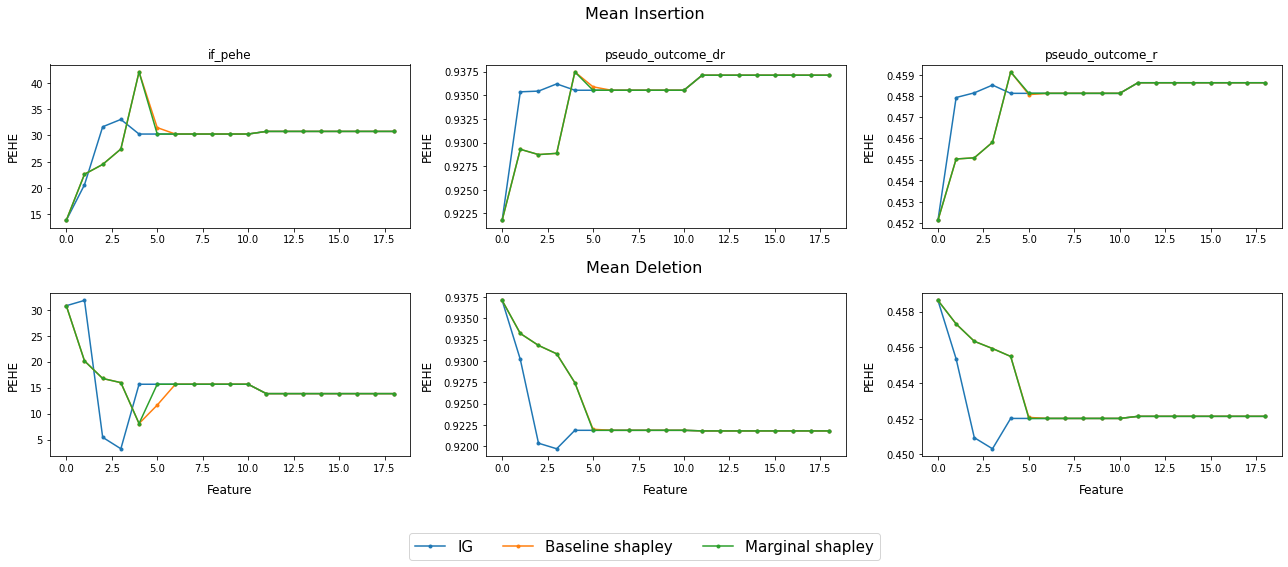

In [258]:
learner = "xlearner"
shuffle = "True"

explainers = [
    "integrated_gradients", 
    "baseline_shapley_value_sampling",
    "marginal_shapley_value_sampling"
    # "naive_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]

# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

auroc_all = {exp: [] for exp in explainers}


# Loop over the different files

seeds = [0, 1, 2,3,4]

for file_num in range(2):  # assuming there are 5 files, from 0 to 4
    
    # if file_num not in [1]:

    for selection_type in selection_types:
        file_path = f"../results/ist3/insertion_deletion_shuffle_{shuffle}_{learner}_seed_{file_num}.pkl"
        results = pkl.load(open(file_path,'rb'))

        for exp_index, exp in enumerate(explainers):
            insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
            deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))
            auroc_all[exp].append(results[exp_index][5])

                

# Create a grid for subplots
gs = gridspec.GridSpec(2, len(selection_types))

# Create figure
fig = plt.figure(figsize=(6 * len(selection_types), 8))

# To keep track of labels and lines for the legend
handles, labels = [], []

# Calculate and plot mean results
for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        if exp == "baseline_shapley_value_sampling":
            label = "Baseline shapley"
        elif exp == "marginal_shapley_value_sampling":
            label = "Marginal shapley"
        elif exp == "integrated_gradients":
            label = "IG"
        else:
            label = exp
        
        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        features_num = len(insertion_results_mean)

        # Insertion subplot
        ax1 = plt.subplot(gs[0, i])
        ax1.set_title(f"{selection_type}")
        ax1.set_ylabel('PEHE', fontsize=12, labelpad=10)
        
        # Plot and store the line and label for legend
        line, = ax1.plot(range(features_num), insertion_results_mean, '-o', markersize=3)
        
        # Deletion subplot
        ax2 = plt.subplot(gs[1, i])
        ax2.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax2.plot(range(features_num), deletion_results_mean, '-o', markersize=3)
        
        # Add the line handle and label only if it doesn't exist
        if label not in labels:
            handles.append(line)
            labels.append(label)

# Set the x-label for only the bottom subplots
for i in range(len(selection_types)):
    ax = plt.subplot(gs[1, i])
    ax.set_xlabel('Feature', fontsize=12, labelpad=10)

# Set main titles for each row, outside of loops, and adjust positions
fig.text(0.5, 0.96, "Mean Insertion", ha='center', fontsize=16)
fig.text(0.5, 0.52, "Mean Deletion", ha='center', fontsize=16)

# Add a single legend for the entire figure with larger font size
# Move legend below the second row
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), fontsize=15, ncol=len(labels))

# Adjust layout and add more space for the main titles
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.4, bottom=0.2)
plt.show()


# # Function to calculate the percentage contribution of cumulative PEHE up to nth feature relative to the total PEHE at final feature
# def calc_cumulative_contribution(n, data):
#     if n >= len(data):
#         raise ValueError(f"Feature index {n} is out of bounds for data of length {len(data)}")
#     percentage_contribution = (data[-1] - data[n] / data[-1]) * 100
#     return percentage_contribution

# # Let's say you want the cumulative contribution of PEHE when up to the 5th feature is added
# n = 4

# # Loop through each explainer and selection type
# for exp in explainers:
#     for selection_type in selection_types:
#         # Get the cumulative PEHE for each feature
#         pehe_values = np.mean(insertion_results_all[exp][selection_type], axis=0)
#         percentage_contribution = calc_cumulative_contribution(n, pehe_values)
        
#         # Print the percentage contribution of PEHE up to nth feature
#         print(f"For {exp} with {selection_type} selection:")
#         print(f"Percentage contribution of PEHE up to {n+1}th feature: {percentage_contribution}%")


In [260]:
auroc_results  = {exp:np.mean(result) for exp, result in auroc_all.items()}

auroc_results

{'integrated_gradients': 0.5494281811830917,
 'baseline_shapley_value_sampling': 0.5440202063895238,
 'marginal_shapley_value_sampling': 0.5440202063895238}